In [1]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly
import plotly.graph_objs as go
import plotly.offline as pyo
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from functools import partial
import face_recognition


tf.test.is_gpu_available()
print(plotly.__version__)
pyo.init_notebook_mode()
tf.__version__





plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
5.18.0


In [2]:
def get_data():
    return pd.read_json(r'C:\Users\epava\ML\Project\train_sample_videos\metadata.json').T

meta=get_data()

Train_set, Val_set = train_test_split(meta,test_size=0.1,random_state=42,stratify=meta['label'])


def display_proposition():
    y = dict()

    y[0] = []
    y[1] = []
    
    for set_name in (np.array(Train_set['label']), np.array(Val_set['label'])):
        y[0].append(np.sum(set_name == 'REAL'))
        y[1].append(np.sum(set_name == 'FAKE'))
    
    trace0 = go.Bar(
        x=['Train Set', 'Validation Set'],
        y=y[0],
        name='REAL',
        marker=dict(color='#33cc33'),
        opacity=0.7
    )
    trace1 = go.Bar(
        x=['Train Set', 'Validation Set'],
        y=y[1],
        name='FAKE',
        marker=dict(color='#ff3300'),
        opacity=0.7
    )
    
    data = [trace0, trace1]
    layout = go.Layout(
        title='Count of classes in each set',
        xaxis={'title': 'Set'},
        yaxis={'title': 'Count'},
        height=800, 
        width=800 
    )
    
    fig = go.Figure(data, layout)
    pyo.plot(fig)

display_proposition()


def face_recog(image):
    face_locations = face_recognition.face_locations(image)
    face_image = None
    for face_location in face_locations:
        # Print the location of each face in this image
        top, right, bottom, left = face_location
        # You can access the actual face itself like this:
        face_image = image[top:bottom, left:right]
    return face_image


def retreive_dataset(set_name, target_size=(256, 256)):  # You can adjust the target_size as needed
    i = 0
    pad = 60
    images, labels = [], []
    for cur, i in enumerate(set_name.index[0:]):
        video_file = f'C:/Users/epava/ML/Project/train_sample_videos/{i}'
        cap = cv2.VideoCapture(video_file)
        success, image = cap.read()
        cap.release()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        face_locations = face_recognition.face_locations(image)

        for face_location in face_locations:
            top, right, bottom, left = face_location
            face_image = image[top-pad:bottom+pad, left-pad:right+pad]
            face_image = cv2.resize(face_image, target_size)  # Resize the face image
            if set_name.loc[i, 'label'] == 'FAKE':
                labels.append(1)
            else:
                labels.append(0)

            images.append(face_image)

    return np.array(images), np.array(labels)

#X_train, y_train = retreive_dataset(Train_set)


In [5]:
print(len(X_train), len(y_train))
tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[256, 256, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

342 342
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 524288)     

In [6]:
history = model.fit(X_train, y_train, epochs=5,batch_size=16)

Epoch 1/5
22/22 [==============================] - 12s 188ms/step - loss: 959.2646 - accuracy: 0.6813
Epoch 2/5
22/22 [==============================] - 3s 129ms/step - loss: 0.7315 - accuracy: 0.7749
Epoch 3/5
22/22 [==============================] - 3s 129ms/step - loss: 0.5381 - accuracy: 0.7661
Epoch 4/5
22/22 [==============================] - 3s 130ms/step - loss: 0.5322 - accuracy: 0.7865
Epoch 5/5
22/22 [==============================] - 3s 129ms/step - loss: 0.8679 - accuracy: 0.7807


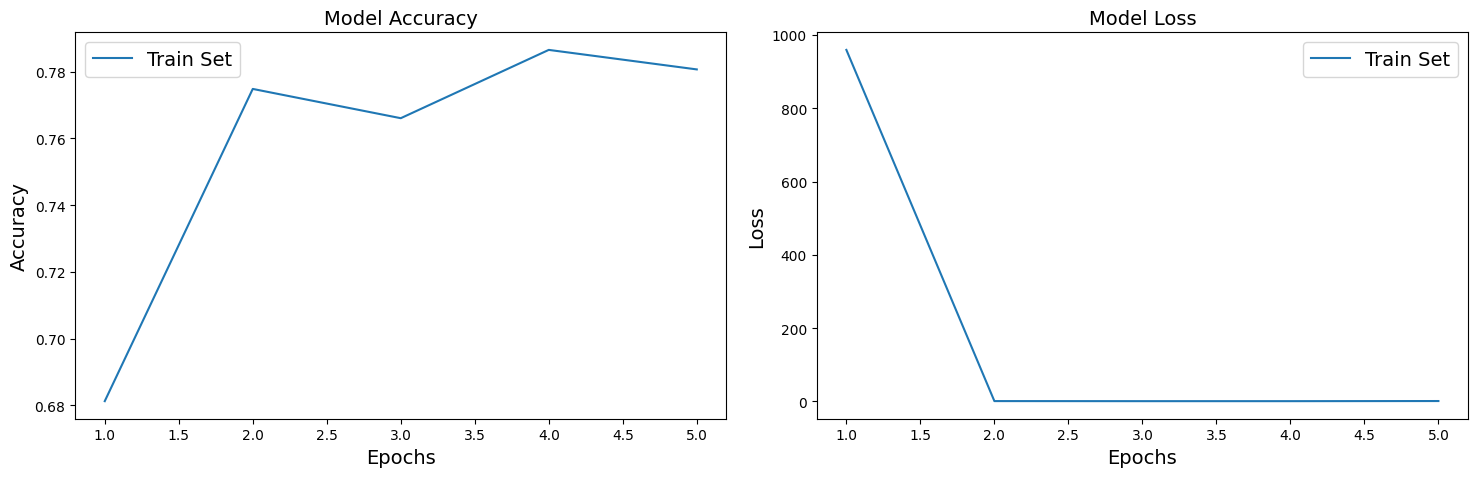

In [7]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [15]:
import random
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file):
    video_url = open(video_file,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)

def sequence_prediction(video_file, target_size=(256, 256)):
    i = 0
    pad = 60
    images, labels = [], []
    video_file = f'C:/Users/epava/ML/Project/train_sample_videos/{video_file}'
    cap = cv2.VideoCapture(video_file)
    success, image = cap.read()
    cap.release()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image)

    if len(face_locations)>0:
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top-pad:bottom+pad, left-pad:right+pad]
        face_image = cv2.resize(face_image, target_size)  # Resize the face image
        images.append(face_image)

    return np.array(images)


ran = random.randint(0, Val_set.shape[0]-1)


video_file = Val_set.index[ran]
print(video_file)
frame = sequence_prediction(video_file)
video_file = r'C:/Users/epava/ML/Project/train_sample_videos/' + video_file

score = model.predict(frame)

print(f"Prediction score {score}")

if(score >= 0.5):
     print(f'The predicted class of the video is FAKE')
else:
     print(f'The predicted class of the video is REAL')

play_video(video_file)




bhaaboftbc.mp4
1/1 [==============================] - 0s 15ms/step
Prediction score [[0.6154474]]
The predicted class of the video is FAKE


In [17]:
import statistics
print((history.history['loss']))
print(history.history['accuracy'])

[959.2646484375, 0.7314940094947815, 0.5380582809448242, 0.5321868062019348, 0.8678881525993347]
[0.6812865734100342, 0.7748538255691528, 0.7660818696022034, 0.7865496873855591, 0.780701756477356]
